<a href="https://colab.research.google.com/github/AmitC04/SCENE-TEXT-SPOTTING-TEXT-RECOGNITION-/blob/main/TEXT_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow opencv-python matplotlib pillow

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [3]:
import keras_tuner as kt
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [4]:
dataset_dir = '/content/dataset'
os.makedirs(os.path.join(dataset_dir, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, 'train', 'labels'), exist_ok=True)


In [5]:
def create_text_image(text, image_size=(128, 32), font=cv2.FONT_HERSHEY_SIMPLEX, font_size=1, thickness=2):
    image = np.ones((image_size[1], image_size[0]), dtype=np.uint8) * 255  # White background
    text_size = cv2.getTextSize(text, font, font_size, thickness)[0]
    text_x = (image_size[0] - text_size[0]) // 2
    text_y = (image_size[1] + text_size[1]) // 2
    cv2.putText(image, text, (text_x, text_y), font, font_size, (0, 0, 0), thickness)
    return image

In [6]:
text_list = ['Hello', 'World', 'ML', 'Syntax', 'Spotting', 'Text', 'Recognition']
for idx, text in enumerate(text_list):
    img = create_text_image(text)
    img_path = os.path.join(dataset_dir, 'train', 'images', f'{idx}.png')
    label_path = os.path.join(dataset_dir, 'train', 'labels', f'{idx}.txt')

    # Save image
    cv2.imwrite(img_path, img)

    # Save label
    with open(label_path, 'w') as label_file:
        label_file.write(text)

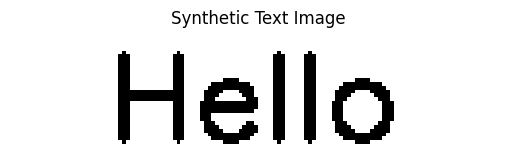

In [7]:
img = cv2.imread(os.path.join(dataset_dir, 'train', 'images', '0.png'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Synthetic Text Image')
plt.axis('off')
plt.show()

In [8]:
def load_and_preprocess_images(dataset_dir):
    image_files = os.listdir(os.path.join(dataset_dir, 'train', 'images'))
    images = []
    labels = []

    for img_file in image_files:
        img_path = os.path.join(dataset_dir, 'train', 'images', img_file)
        label_path = os.path.join(dataset_dir, 'train', 'labels', img_file.replace('.png', '.txt'))

        # Load image and preprocess
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 32)) / 255.0  # Normalize and resize
        images.append(img)

        # Load label
        with open(label_path, 'r') as f:
            label = f.read().strip()
        labels.append(label)

    return np.array(images), labels

In [9]:
images, labels = load_and_preprocess_images(dataset_dir)

In [10]:
images = images.reshape(-1, 32, 128, 1)

In [11]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [12]:
y_train_encoded = to_categorical(encoded_labels, num_classes=26)

In [13]:
# Split data into train and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(images, y_train_encoded, test_size=0.2, random_state=42)

In [14]:
# Define a model with hyperparameters
from tensorflow.keras import layers  # Import the 'layers' module

def create_model(hp):
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(32, 128, 1)))

    # Adding convolutional layers with hyperparameters
    for i in range(hp.Int('conv_layers', 1, 3)):  # Hyperparameter for the number of convolutional layers
        model.add(layers.Conv2D(
            filters=hp.Int(f'conv_{i}_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'conv_{i}_kernel_size', values=[3, 5]),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Adding Dense layers with hyperparameters
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(layers.Dense(26, activation='softmax'))  # Output layer for 26 classes (lowercase letters)

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
# Initialize Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='/content/tuner_dir',
    project_name='text_recognition_tuning'
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [16]:
# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 10s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 02m 17s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4000 - loss: 2.8482 - val_accuracy: 0.0000e+00 - val_loss: 3.7930
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.6000 - loss: 2.0084 - val_accuracy: 0.0000e+00 - val_loss: 5.1156
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6000 - loss: 1.2960 - val_accuracy: 0.0000e+00 - val_loss: 6.9825
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.8112 - val_accuracy: 0.0000e+00 - val_loss: 9.1491
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.5848 - val_accuracy: 0.0000e+00 - val_loss: 11.0627
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.3625 - val_accuracy: 0.0000e+00 - val_loss: 12.7091
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.1851 - val_accuracy: 0.0000e+00 - val_loss: 14.2244
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.1004 - val_accura

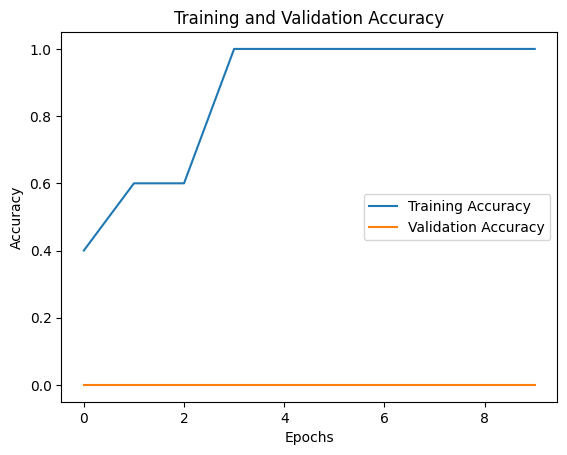

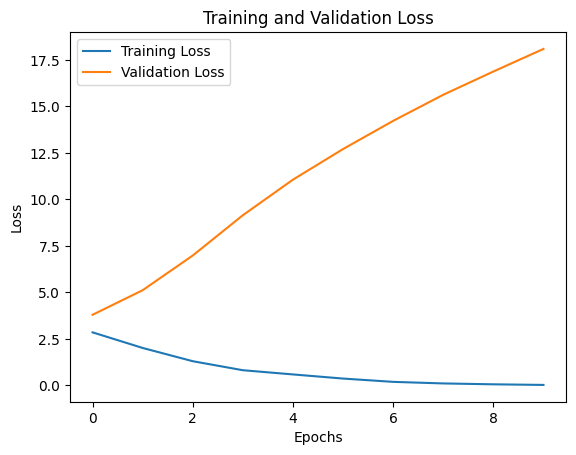

In [17]:
# Train the best model after hyperparameter tuning
history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Visualize training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


THE ABOVE CONDITON IS OVERFITTING ,SINCE VAL LOSS INC AND TRAIN LOSS DEC AND VALIDATION ACCURACY IS CONST. OR DROP


TRAINING ACCURACY IS INCREASING AND VALIDATION IS CONST. i.e=0,